# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [2.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [11]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt


In [12]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, init_zero:bool=False, seed:int=1) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        if init_zero:
          self.weights = np.zeros((input_size, output_size))
        else:
          np.random.seed(seed)
          self.weights = np.random.uniform(-1/np.sqrt(input_size), 1/np.sqrt(input_size), (input_size, output_size))
        self.bias = np.ones(output_size)
        self.grad_weights = np.zeros((input_size, output_size))
        self.grad_bias = np.zeros(output_size)
        self.saved_input = np.zeros(input_size)

    def forward(self, x:np.ndarray)->np.ndarray:
        self.saved_input = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, output_error_derivative)->np.ndarray:
        self.grad_bias = output_error_derivative
        self.grad_weights += np.outer(self.saved_input, output_error_derivative)

        return np.dot(output_error_derivative, self.weights.T)

    def zero_grad(self):
        self.grad_weights = np.zeros((self.input_size, self.output_size))
        self.grad_bias = np.zeros(self.output_size)

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.saved_output = np.tanh(x)
        return self.saved_output

    def backward(self, output_error_derivative)->np.ndarray:
        tanh_derivative = 1 - self.saved_output**2
        return tanh_derivative * output_error_derivative

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
          x = layer.forward(x)
        return x

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            x_test:np.ndarray,
            y_test:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        train_losses = []
        test_losses = []
        for epoch in range(epochs):
          train_loss = 0.0

          for i in range(len(x_train)):
              for layer in self.layers:
                  if isinstance(layer, FullyConnected):
                    layer.zero_grad()

              output = self(x_train[i])

              loss = self.loss.loss(output, y_train[i])

              loss_derivative = self.loss.loss_derivative(output, y_train[i])
              for layer in reversed(self.layers):
                  loss_derivative = layer.backward(loss_derivative)

              for layer in self.layers:
                  if isinstance(layer, FullyConnected):
                      layer.weights -= self.learning_rate * layer.grad_weights
                      layer.bias -= self.learning_rate * layer.grad_bias
              train_loss += loss

          if verbose:
              print(f'Epoch: {epoch + 1} Training Loss: {train_loss / len(x_train)}')
          train_losses.append(train_loss / len(x_train))

          test_loss = 0.0
          for i in range(len(x_test)):
            output = self(x_test[i])
            test_loss += self.loss.loss(output, y_test[i])
          test_losses.append(test_loss / len(x_test))

        return train_losses, test_losses

# Eksperymenty

In [13]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", return_X_y=True)
X_normalized = (X / 255.0) * 2 - 1
X_train, X_test = X_normalized[:60000], X_normalized[60000:]
y_train, y_test = y[:60000], y[60000:]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

In [14]:
def cross_entropy_loss(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    epsilon = 1e-12
    x = np.clip(x, epsilon, 1. - epsilon)
    return -np.sum(y * np.log(x))

def cross_entropy_derivative(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return x - y

def mse_loss(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.mean((x - y) ** 2)

def mse_derivative(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return 2 * (x - y) / x.size

In [15]:
def plot_loss(eloss, tloss):
    plt.figure(figsize=(10, 6))
    plt.plot(eloss, label='Training Loss', color='blue')
    plt.plot(tloss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def train(model:Network, epochs):
  model.compile(Loss(mse_loss, mse_derivative))
  e, t = model.fit(X_train.values, y_train_one_hot, X_test.values, y_test_one_hot, epochs, 0.01, 1)
  plot_loss(e, t)
  accuracy(model, X_test, y_test)

In [17]:
def train_getloss(model:Network, epochs):
  model.compile(Loss(mse_loss, mse_derivative))
  e, t = model.fit(X_train.values, y_train_one_hot, X_test.values, y_test_one_hot, epochs, 0.01, 1)
  return e, t

# Wnioski

In [18]:
def accuracy(net: Network, X: np.ndarray, y: np.ndarray):
  correct = 0

  for i in range(len(X)):
      output = net(X.values[i])
      predicted_label = np.argmax(output)
      true_label = y.iloc[i]

      if predicted_label == true_label:
          correct += 1
  accuracy = correct / len(X)
  print(f"Accuracy: {accuracy * 100:.2f}%")

In [20]:
seeds = [10, 42, 99]
results = {}

for s in seeds:
    model = Network([
        FullyConnected(784, 256, False, s),
        Tanh(),
        FullyConnected(256, 10, True, s)
    ], 0.01)

    train_loss, val_loss = train_getloss(model, 10)
    results[s] = (train_loss, val_loss)


Epoch: 1 Training Loss: 0.027346867147626422
Epoch: 2 Training Loss: 0.015727242259737564
Epoch: 3 Training Loss: 0.01359577839923725
Epoch: 4 Training Loss: 0.012434150941345786
Epoch: 5 Training Loss: 0.01165637730823845
Epoch: 6 Training Loss: 0.011077976469840916
Epoch: 7 Training Loss: 0.010624429446035404
Epoch: 8 Training Loss: 0.010258651924219878
Epoch: 9 Training Loss: 0.00995472119009379
Epoch: 10 Training Loss: 0.009695057942511853
Epoch: 1 Training Loss: 0.028009980137522886
Epoch: 2 Training Loss: 0.01618334218133029
Epoch: 3 Training Loss: 0.01397241698628453
Epoch: 4 Training Loss: 0.012796546595090491
Epoch: 5 Training Loss: 0.012014300108542257
Epoch: 6 Training Loss: 0.011426626235414614
Epoch: 7 Training Loss: 0.010955929314715352
Epoch: 8 Training Loss: 0.010568316273638812
Epoch: 9 Training Loss: 0.010243225397541262
Epoch: 10 Training Loss: 0.009965120875565066
Epoch: 1 Training Loss: 0.027753216540989032
Epoch: 2 Training Loss: 0.015816050154622903
Epoch: 3 Trai

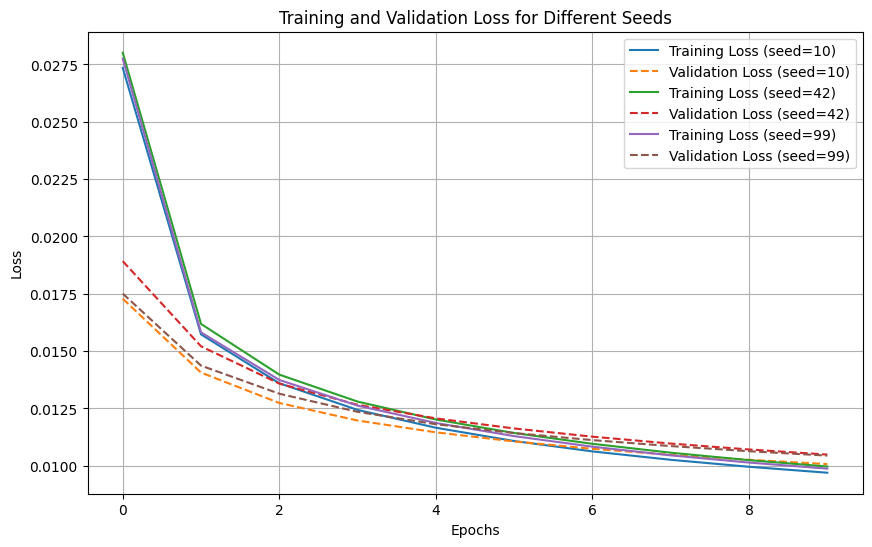

In [21]:
plt.figure(figsize=(10, 6))
for s, (train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f'Training Loss (seed={s})')
    plt.plot(val_loss, '--', label=f'Validation Loss (seed={s})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Seeds')
plt.legend()
plt.grid(True)
plt.show()

Pomysły:
porównanie czasu - liczymy dla kazdej probki a SGD

In [22]:
seeds = [10, 42, 99]
results = {}

for s in seeds:
    model = Network([
        FullyConnected(784, 32, False, s),
        Tanh(),
        FullyConnected(32, 10, True, s)
    ], 0.01)

    train_loss, val_loss = train_getloss(model, 10)
    results[s] = (train_loss, val_loss)

Epoch: 1 Training Loss: 0.02926802402005107
Epoch: 2 Training Loss: 0.01753444792440221
Epoch: 3 Training Loss: 0.01573019776860488
Epoch: 4 Training Loss: 0.014491912216081072
Epoch: 5 Training Loss: 0.01369072810952892
Epoch: 6 Training Loss: 0.01313303210113418
Epoch: 7 Training Loss: 0.012711944532282492
Epoch: 8 Training Loss: 0.012375440519975722
Epoch: 9 Training Loss: 0.012096409271840514
Epoch: 10 Training Loss: 0.011869331128252315
Epoch: 1 Training Loss: 0.029507296742267253
Epoch: 2 Training Loss: 0.017151271335106123
Epoch: 3 Training Loss: 0.014999316615651983
Epoch: 4 Training Loss: 0.01401149528965616
Epoch: 5 Training Loss: 0.01336711319484852
Epoch: 6 Training Loss: 0.01287215885211232
Epoch: 7 Training Loss: 0.012480891275711207
Epoch: 8 Training Loss: 0.01217055168645499
Epoch: 9 Training Loss: 0.011923103853338324
Epoch: 10 Training Loss: 0.011721944915663413
Epoch: 1 Training Loss: 0.027504680694209496
Epoch: 2 Training Loss: 0.016272832929804644
Epoch: 3 Training

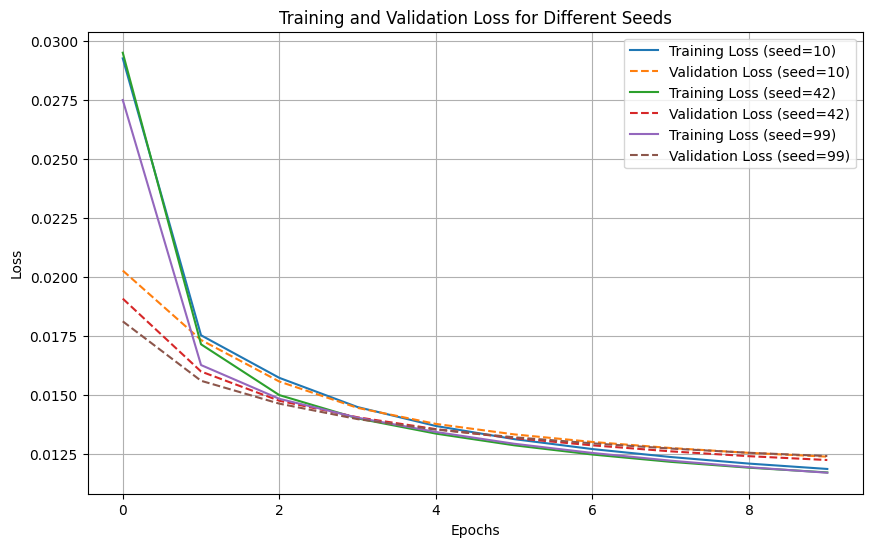

In [23]:
plt.figure(figsize=(10, 6))
for s, (train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f'Training Loss (seed={s})')
    plt.plot(val_loss, '--', label=f'Validation Loss (seed={s})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Seeds')
plt.legend()
plt.grid(True)
plt.show()


Epoch: 1 Training Loss: 0.039180104517896545
Epoch: 2 Training Loss: 0.022574388152248177
Epoch: 3 Training Loss: 0.02041446891228346
Epoch: 4 Training Loss: 0.01957290183811474
Epoch: 5 Training Loss: 0.018266557332712038


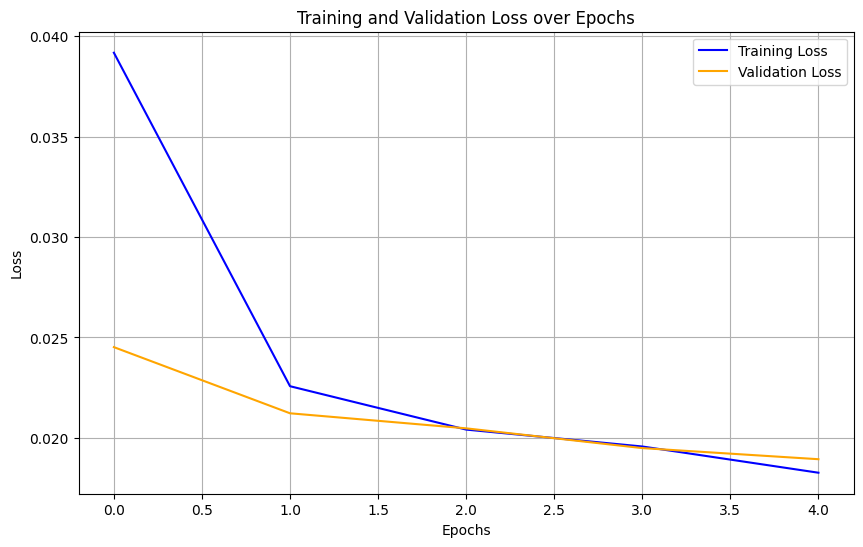

Accuracy: 89.69%


In [24]:
model = Network([FullyConnected(784, 16, False), Tanh(), FullyConnected(16, 10, True)], 0.01)
train(model, 5)

In [26]:
learning_rates = [0.001, 0.01, 0.1]
seed = 42
results = {}

for lr in learning_rates:
    model = Network([
        FullyConnected(784, 16, False, seed),
        Tanh(),
        FullyConnected(16, 10, True, seed)
    ], lr)
    train_loss, val_loss = train_getloss(model, 10)

    results[lr] = (train_loss, val_loss)

Epoch: 1 Training Loss: 0.08867741200861755
Epoch: 2 Training Loss: 0.05659373676796445
Epoch: 3 Training Loss: 0.03818301289275731
Epoch: 4 Training Loss: 0.030912970963384367
Epoch: 5 Training Loss: 0.027809457153654543
Epoch: 6 Training Loss: 0.025600128384296268
Epoch: 7 Training Loss: 0.02368711230159275
Epoch: 8 Training Loss: 0.022326847922576512
Epoch: 9 Training Loss: 0.021293236908124697
Epoch: 10 Training Loss: 0.02052700524124891
Epoch: 1 Training Loss: 0.03668925470724317
Epoch: 2 Training Loss: 0.020375509761333673
Epoch: 3 Training Loss: 0.018521243022926338
Epoch: 4 Training Loss: 0.01789540615805317
Epoch: 5 Training Loss: 0.017311899631493467
Epoch: 6 Training Loss: 0.016616299479021993
Epoch: 7 Training Loss: 0.016108633054453248
Epoch: 8 Training Loss: 0.015577247712200567
Epoch: 9 Training Loss: 0.015229653891506531
Epoch: 10 Training Loss: 0.015020901085897926
Epoch: 1 Training Loss: 0.02942050782467325
Epoch: 2 Training Loss: 0.02315299398579994
Epoch: 3 Training

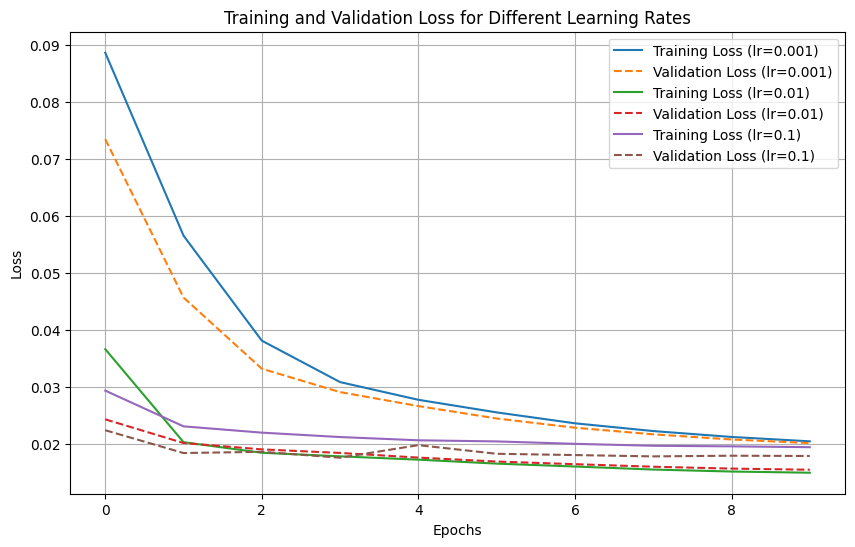

In [27]:
plt.figure(figsize=(10, 6))
for lr, (train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f'Training Loss (lr={lr})')
    plt.plot(val_loss, '--', label=f'Validation Loss (lr={lr})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()